In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Datasets', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Datasets', train=False, download=True, transform=transform)

class_names = train_data.classes

## 1. Create data loaders

In [32]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## 2. Examine a batch of images 

In [14]:
for images, labels in train_loader:
    break

In [15]:
labels

tensor([8, 5, 9, 4, 3, 0, 0, 6, 5, 7])

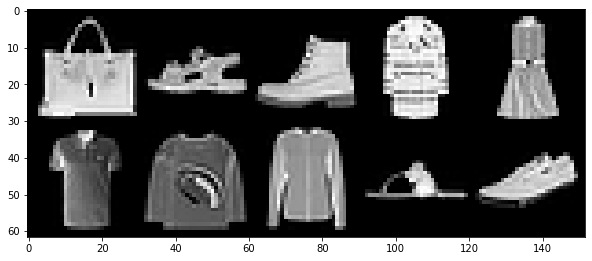

In [16]:
plt.figure(figsize=(10, 7))
im = make_grid(images, nrow=5)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Label:  [8 5 9 4 3 0 0 6 5 7]
Label:  ['Bag', 'Sandal', 'Ankle boot', 'Coat', 'Dress', 'T-shirt/top', 'T-shirt/top', 'Shirt', 'Sandal', 'Sneaker']


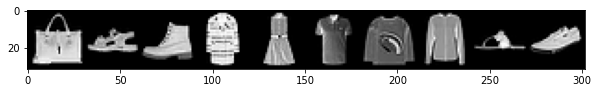

In [17]:
plt.figure(figsize=(10, 7))
print('Label: ', labels.numpy())
print('Label: ', [class_names[i] for i in labels])
im = make_grid(images, nrow=10)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [18]:
images[0].shape

torch.Size([1, 28, 28])

In [19]:
conv = nn.Conv2d(1, 1, 5, 1)
for x,labels in train_loader:
    print('Orig size:',x.shape)
    break
x = conv(x)
print('Down size:',x.shape)

Orig size: torch.Size([10, 1, 28, 28])
Down size: torch.Size([10, 1, 24, 24])


In [20]:
x = F.max_pool2d(x, 2, 2)
print('Down size:',x.shape)

Down size: torch.Size([10, 1, 12, 12])


## 3. CNN Definition

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
    
torch.manual_seed(101)
model = ConvolutionalNetwork()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
for param in model.parameters():
    print(param.numel())
print('----------')
print(sum([param.numel() for param in model.parameters()]))

54
6
864
16
40000
100
1000
10
----------
42050


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [38]:
epochs = 5

train_losses = []
test_losses = []
test_acc = []

for i in range(epochs):
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%100 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')
    train_losses.append(loss)

    with torch.no_grad():
        correct = 0
        for (X_test, y_test) in test_loader:
            y_pred = model(X_test)
            predicted = torch.max(y_pred.data, 1)[1]
            correct += (predicted == y_test)
            loss = criterion(y_pred, y_test)
        test_losses.append(loss)
        test_acc.append(correct)

Epoch: 0  Batch: 100  Loss: 0.6180404424667358
Epoch: 0  Batch: 200  Loss: 0.4088360667228699
Epoch: 0  Batch: 300  Loss: 0.25284233689308167
Epoch: 0  Batch: 400  Loss: 0.5768767595291138
Epoch: 0  Batch: 500  Loss: 0.4618207812309265
Epoch: 0  Batch: 600  Loss: 0.4707976281642914
Epoch: 0  Batch: 700  Loss: 0.9938770532608032
Epoch: 0  Batch: 800  Loss: 0.5640703439712524
Epoch: 0  Batch: 900  Loss: 0.42939433455467224
Epoch: 0  Batch: 1000  Loss: 0.2708433270454407
Epoch: 0  Batch: 1100  Loss: 0.24076302349567413
Epoch: 0  Batch: 1200  Loss: 0.28965169191360474
Epoch: 0  Batch: 1300  Loss: 0.1371903270483017
Epoch: 0  Batch: 1400  Loss: 0.5742713212966919
Epoch: 0  Batch: 1500  Loss: 0.5613599419593811
Epoch: 0  Batch: 1600  Loss: 0.5359313488006592
Epoch: 0  Batch: 1700  Loss: 0.7848736047744751
Epoch: 0  Batch: 1800  Loss: 0.4859459400177002
Epoch: 0  Batch: 1900  Loss: 0.1901891529560089
Epoch: 0  Batch: 2000  Loss: 0.4260842800140381
Epoch: 0  Batch: 2100  Loss: 0.14765094220638

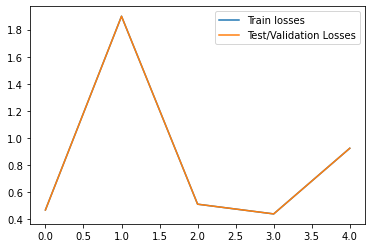

In [42]:
plt.plot(train_losses, label='Train losses')
plt.plot(train_losses, label='Test/Validation Losses')
plt.legend()

In [43]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1]
        correct += (predicted == y_test).sum()

print(correct/len(test_loader))

tensor(8.3760)
